# Elastic Net Model

Elastic net model was done with the same features that the Lasso model had. The elastic net chose the same alpha and has an L1 ratio of 1. So elastic net is redundant to lasso results.

#### Loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

#### Loading data 

In [2]:
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

#### Adding previous rent features.

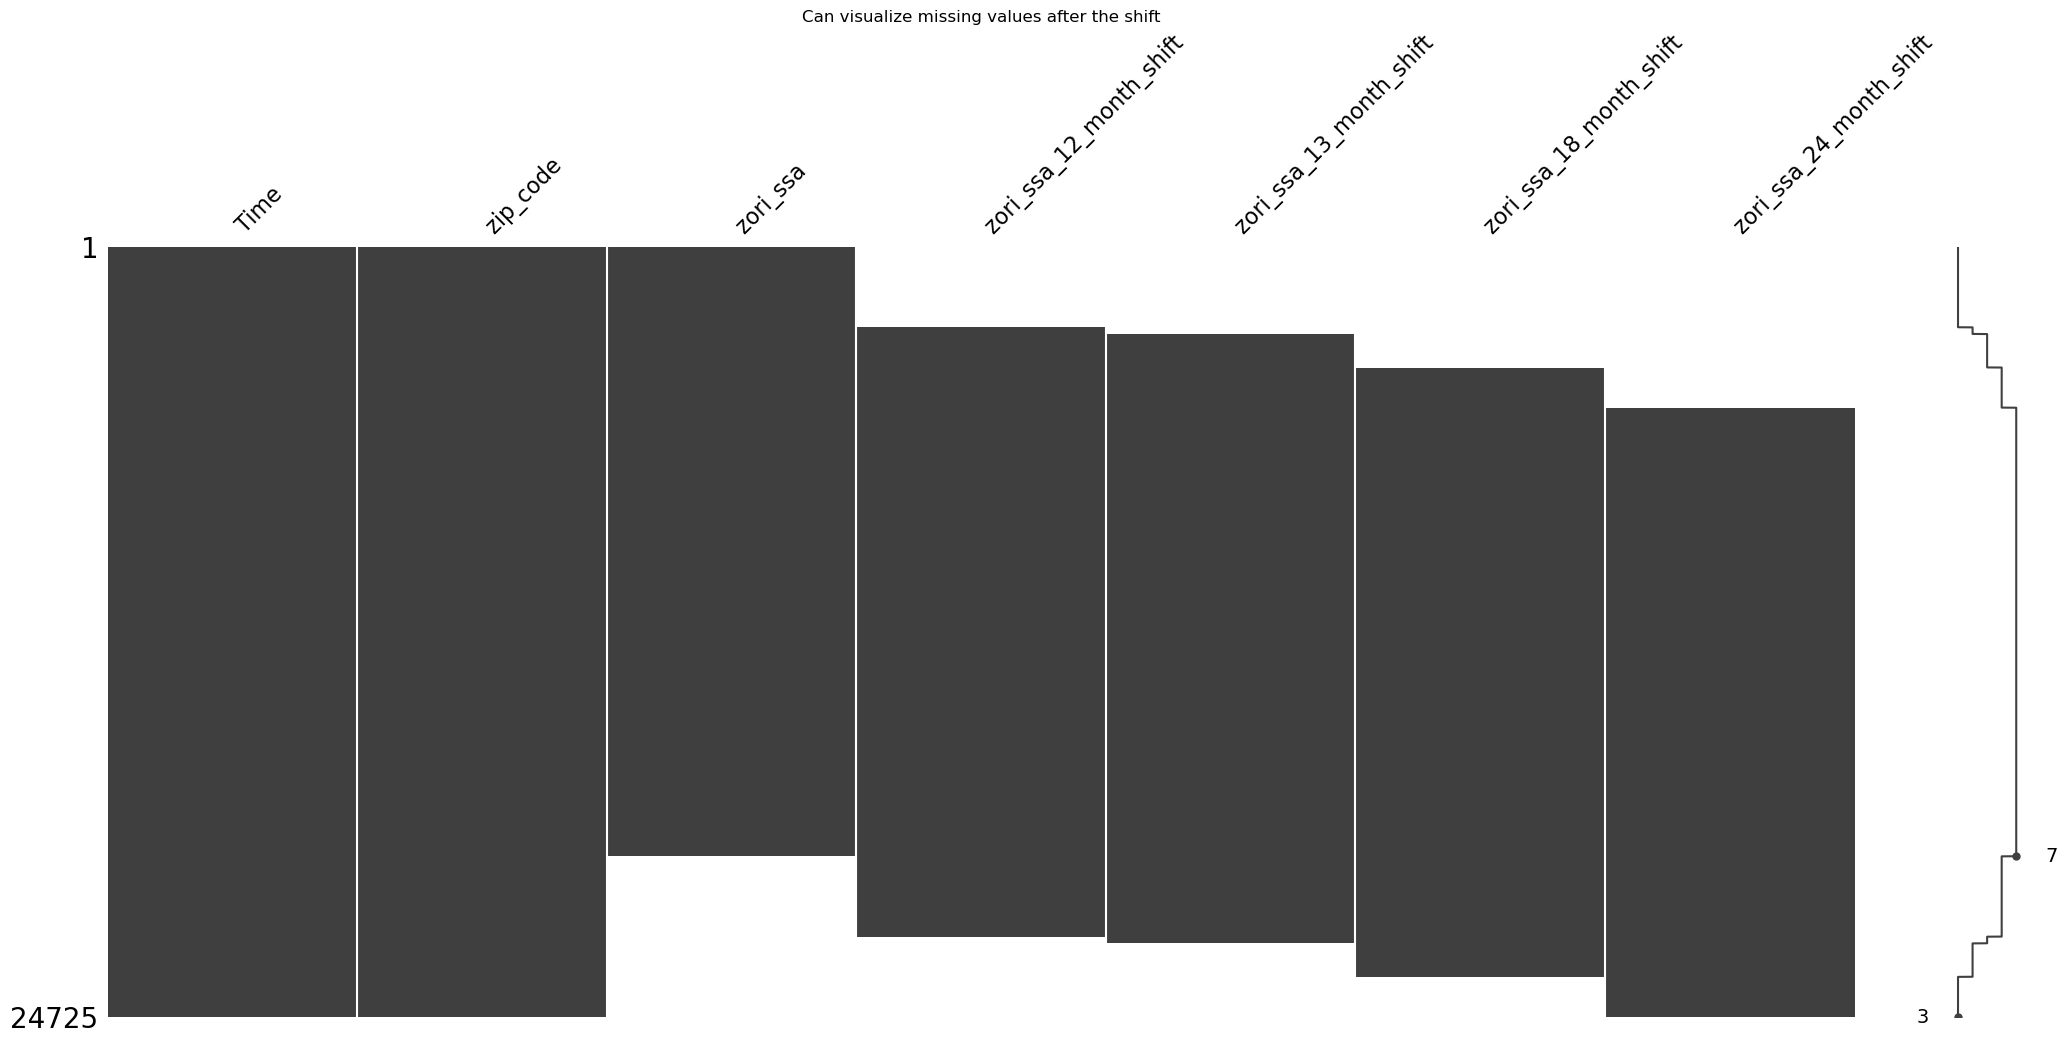

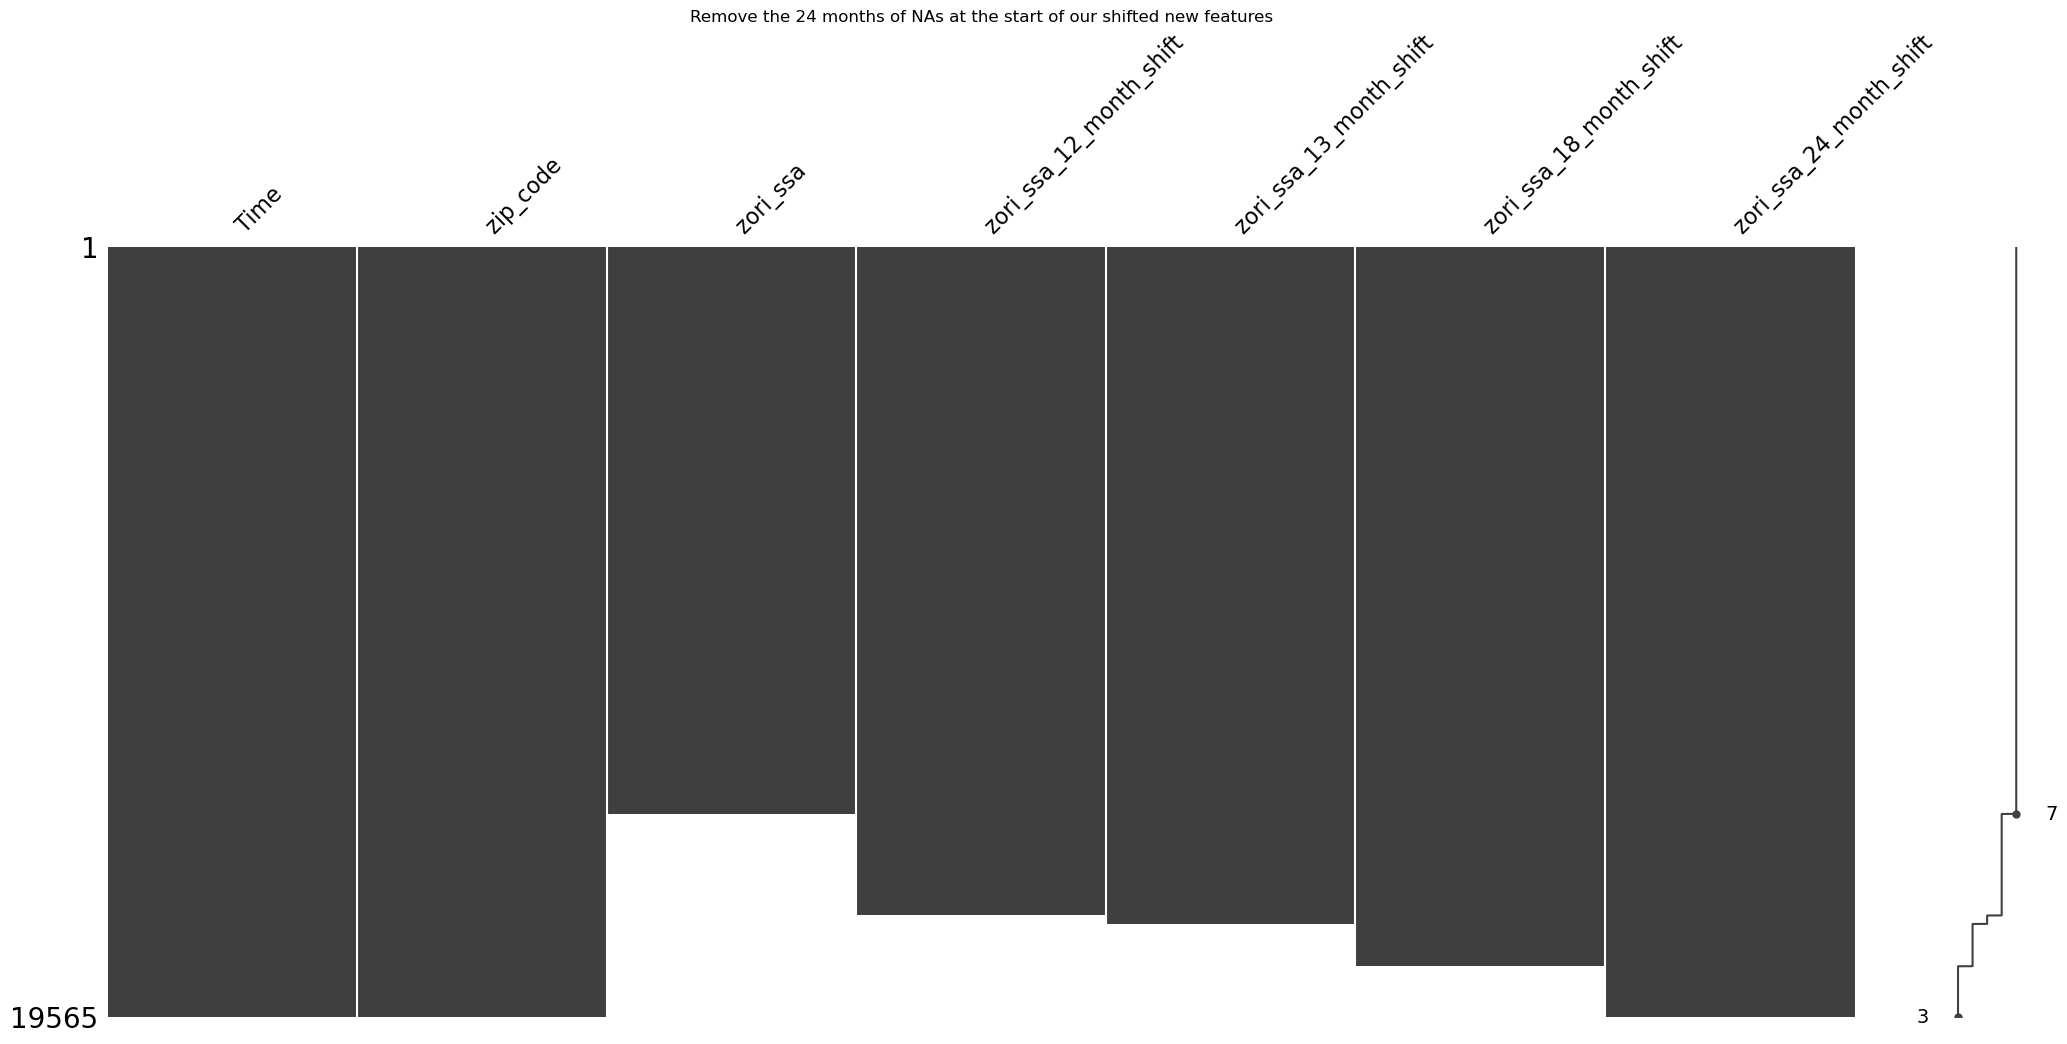

In [3]:
# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
msno.matrix(zri_shift)
plt.title('Can visualize missing values after the shift')
plt.show()
zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
msno.matrix(zri_shift)
plt.title('Remove the 24 months of NAs at the start of our shifted new features')
plt.show()
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

# limiting columns to only those selected by lasso.
zri_shift = zri_shift[['Time','zip_code','zori_ssa', 
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]

#### Adding non rent features.

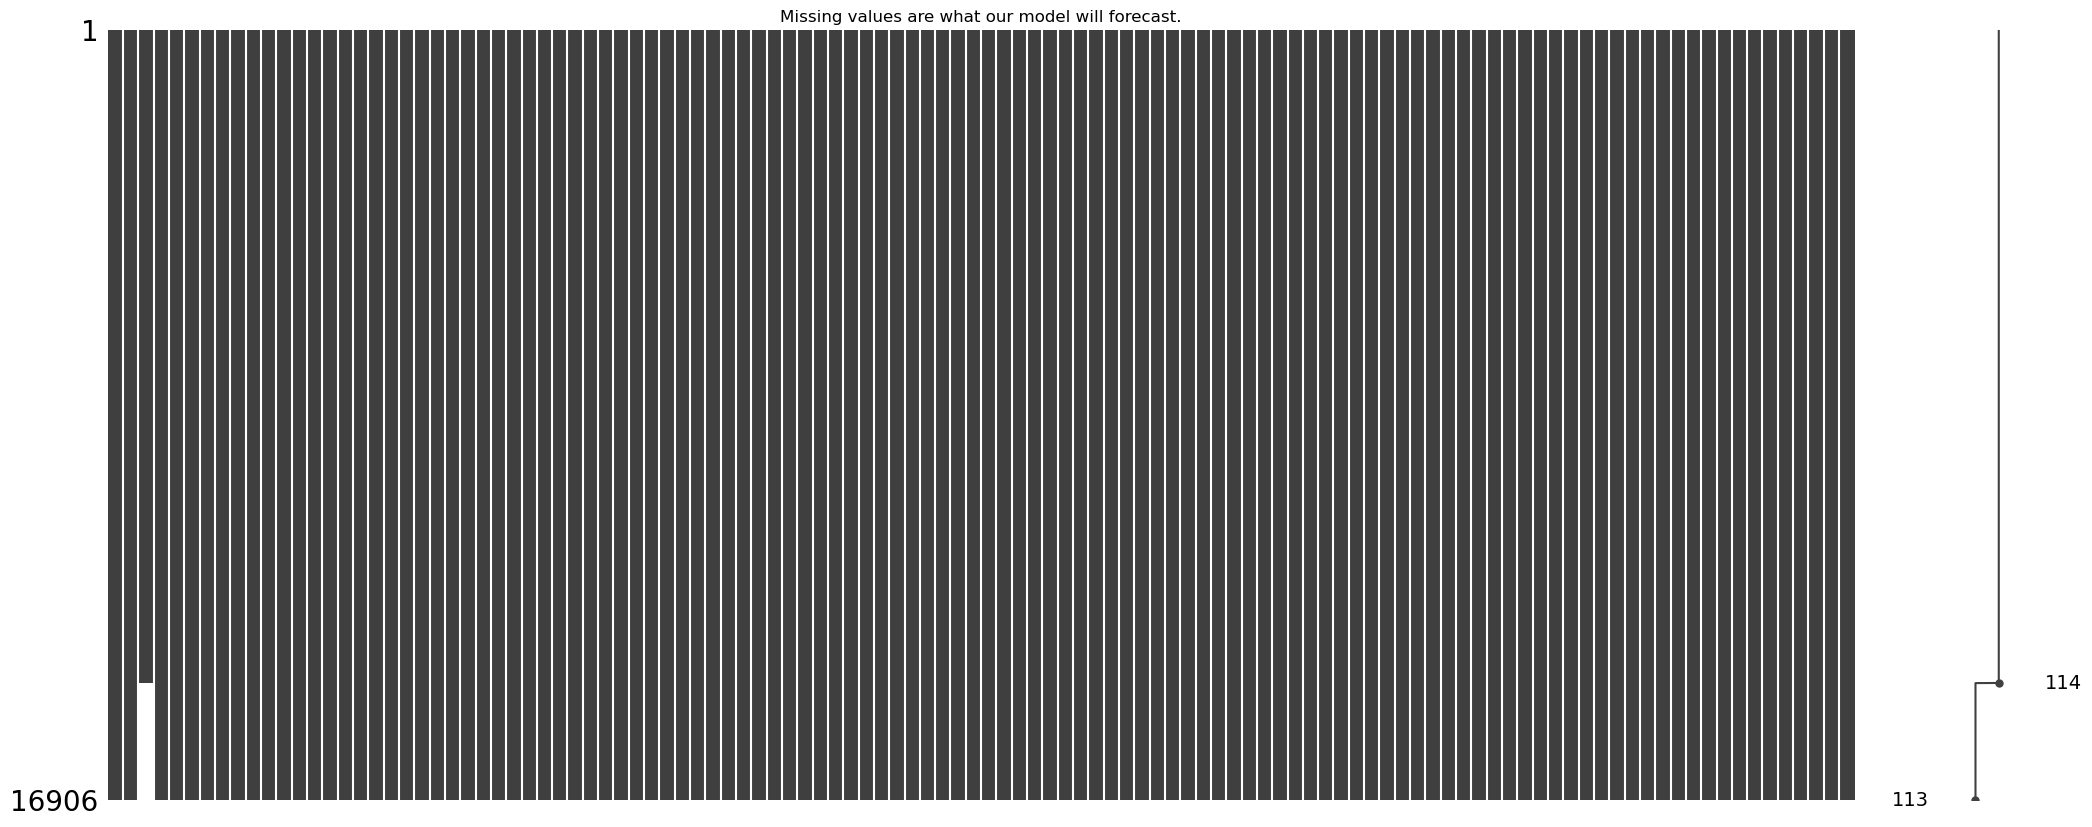

In [4]:
# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)

# this now should have no missing values except for the last year when 
# we are doing a forecast
msno.matrix(merged_df)
plt.title('Missing values are what our model will forecast.')
plt.show()

#### Preparing data to be put into our model

In [5]:
# creating list of variables to put into the model. initialy is all non index and target
X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_built_1960_to_1969_annual_pct_change_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'housing_units_5_to_9_units_annual_pct_change_36_month_shift',
    'median_household_income_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',
    'female_30_to_34_annual_pct_change_36_month_shift',
    'housing_units_over_50_units_annual_pct_change_36_month_shift',
]
# # then remove variables that don't work for that given model.
# bad_X_vals = [
#              ]
# X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
post_train = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = post_train.loc[post_train['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
forecast = post_train.loc[post_train['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test second
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)

#### Model Training

In [6]:
scaler = StandardScaler(with_mean=False)
net = ElasticNet(max_iter = 50000)

l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
alpha = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]
tuned_parameters = [{'alpha': alpha, 'l1_ratio': l1_ratio}]
print(f'Performing Grid Search with \nalphas of: {alpha}\nl1_ratios of: {l1_ratio}')
clf = GridSearchCV(net, tuned_parameters, 
                   cv=5,n_jobs = -1, verbose=3,
                   scoring = 'neg_root_mean_squared_error')

clf.fit(X, y)

y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted
print(f"Best alpha {clf.best_params_['alpha']}")
print(f"Best l1_ratio {clf.best_params_['l1_ratio']}")

Performing Grid Search with 
alphas of: [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]
l1_ratios of: [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best alpha 0.1
Best l1_ratio 1


It is the same as the lasso model. :(